In [1]:
!pip install tensorflow
!pip install cuda-python

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.9/22.9 MB 5.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 5.9 MB/s eta 0:00:0000:0100:01
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from keras import layers,models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import ResNet50
from keras import Model
from keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

2024-03-17 08:37:20.019772: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-17 08:37:20.019832: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-17 08:37:20.095413: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-17 08:37:20.233633: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-17 08:37:22.449923: W tensorflow/compiler/tf2

In [3]:
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [4]:
dataset = "../../SmartBin/data/raw_data/trash_dataset"
walk_through_dir(dataset)

There are 4 directories and 0 images in '../../SmartBin/data/raw_data/trash_dataset'.
There are 0 directories and 801 images in '../../SmartBin/data/raw_data/trash_dataset/metal'.
There are 0 directories and 1005 images in '../../SmartBin/data/raw_data/trash_dataset/plastic'.
There are 0 directories and 1187 images in '../../SmartBin/data/raw_data/trash_dataset/paper'.
There are 0 directories and 914 images in '../../SmartBin/data/raw_data/trash_dataset/glass'.


In [5]:
# Đường dẫn đến thư mục chứa dataset
data_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(data_dir.glob(r'**/*.JPG')) + list(data_dir.glob(r'**/*.jpg')) + list(data_dir.glob(r'**/*.png')) + list(data_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [6]:
image_df

,Filepath,Label
0,../../SmartBin/data/raw_data/trash_dataset/met...,metal
1,../../SmartBin/data/raw_data/trash_dataset/met...,metal
2,../../SmartBin/data/raw_data/trash_dataset/met...,metal
3,../../SmartBin/data/raw_data/trash_dataset/met...,metal
4,../../SmartBin/data/raw_data/trash_dataset/met...,metal
...,...,...
4038,../../SmartBin/data/raw_data/trash_dataset/pap...,paper
4039,../../SmartBin/data/raw_data/trash_dataset/gla...,glass
4040,../../SmartBin/data/raw_data/trash_dataset/gla...,glass
4041,../../SmartBin/data/raw_data/trash_dataset/gla...,glass


[ 419  846  798 1515 1597 3632 3814 2622  219 4024  783  704 1735 2440
 3181 1603]


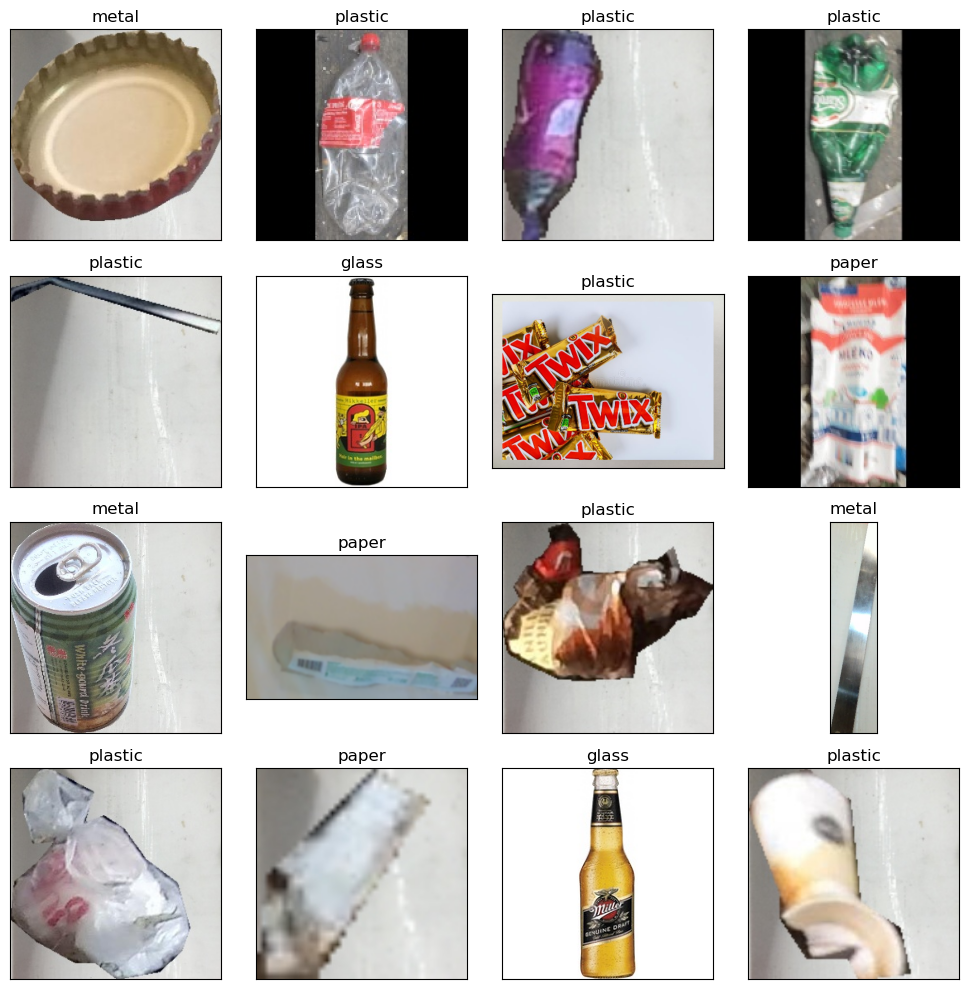

In [7]:
random_index = np.random.randint(0, len(image_df), 16)
print(random_index)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [8]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [9]:
train_df.shape

(3234, 2)

In [10]:
test_df.shape

(809, 2)

In [11]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

In [12]:
import os

# Định nghĩa các tham số cho dataset
batch_size = 32
img_size = (200, 200)

# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2588 validated image filenames belonging to 4 classes.
Found 646 validated image filenames belonging to 4 classes.
Found 809 validated image filenames belonging to 4 classes.


In [13]:
print(train_images.classes[0:10])

[2, 1, 1, 1, 3, 2, 3, 3, 3, 1]


In [14]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  #layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

2024-03-17 08:37:25.408161: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-17 08:37:25.408475: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-17 08:37:25.684930: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required l

In [15]:
#Loading pretrained model
pretrained_model=tf.keras.applications.ResNet50(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet',
        pooling='avg'
)

94765736/94765736 [==============================] - 16s 0us/step


In [16]:
pretrained_model.trainable = False

In [17]:
# Create checkpoint callback
checkpoint_path = "bags_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [18]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 20,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [19]:
inputs=pretrained_model.inputs
x = resize_and_rescale(inputs)
x=Dense(256,activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(4, activation='softmax')(x)

In [20]:
model=Model(inputs,outputs)

In [21]:
model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=20,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "bag_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/bag_classification/20240317-083744
Epoch 1/20


2024-03-17 08:37:46.038867: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2024-03-17 08:37:46.129155: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2024-03-17 08:37:46.152001: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 106463232 exceeds 10% of free system memory.
2024-03-17 08:37:46.181227: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2024-03-17 08:37:46.196814: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.


81/81 [==============================] - 91s 1s/step - loss: 0.9768 - accuracy: 0.5908 - val_loss: 0.6147 - val_accuracy: 0.7554
Epoch 2/20
81/81 [==============================] - 83s 1s/step - loss: 0.6181 - accuracy: 0.7589 - val_loss: 0.4966 - val_accuracy: 0.8142
Epoch 3/20
81/81 [==============================] - 84s 1s/step - loss: 0.5133 - accuracy: 0.8118 - val_loss: 0.4632 - val_accuracy: 0.8189
Epoch 4/20
81/81 [==============================] - 85s 1s/step - loss: 0.4350 - accuracy: 0.8377 - val_loss: 0.4174 - val_accuracy: 0.8514
Epoch 5/20
81/81 [==============================] - 86s 1s/step - loss: 0.3760 - accuracy: 0.8640 - val_loss: 0.3985 - val_accuracy: 0.8622
Epoch 6/20
81/81 [==============================] - 85s 1s/step - loss: 0.3386 - accuracy: 0.8791 - val_loss: 0.3946 - val_accuracy: 0.8653
Epoch 7/20
81/81 [==============================] - 85s 1s/step - loss: 0.2848 - accuracy: 0.8953 - val_loss: 0.3921 - val_accuracy: 0.8700
Epoch 8/20
81/81 [=============

In [22]:
history.history

{'loss': [0.9768322706222534,
  0.6180709600448608,
  0.5133193135261536,
  0.43504321575164795,
  0.3759605586528778,
  0.33859503269195557,
  0.2847990393638611,
  0.2553924024105072,
  0.23269395530223846,
  0.19609391689300537,
  0.17003890872001648,
  0.15225522220134735,
  0.12835170328617096,
  0.12014218419790268,
  0.09815645217895508,
  0.08560984581708908,
  0.07466984540224075,
  0.0657389909029007,
  0.0524430088698864,
  0.05383913964033127],
 'accuracy': [0.5908036828041077,
  0.7588871717453003,
  0.8118237853050232,
  0.8377125263214111,
  0.8639876246452332,
  0.8790571689605713,
  0.895285964012146,
  0.9095826745033264,
  0.9188562631607056,
  0.9327666163444519,
  0.9439721703529358,
  0.9536321759223938,
  0.9590417146682739,
  0.9671561121940613,
  0.9733384847640991,
  0.978748083114624,
  0.9837712645530701,
  0.9841576218605042,
  0.989180862903595,
  0.989180862903595],
 'val_loss': [0.6147030591964722,
  0.49661004543304443,
  0.46322721242904663,
  0.417398

In [23]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.56490
Test Accuracy: 82.20%


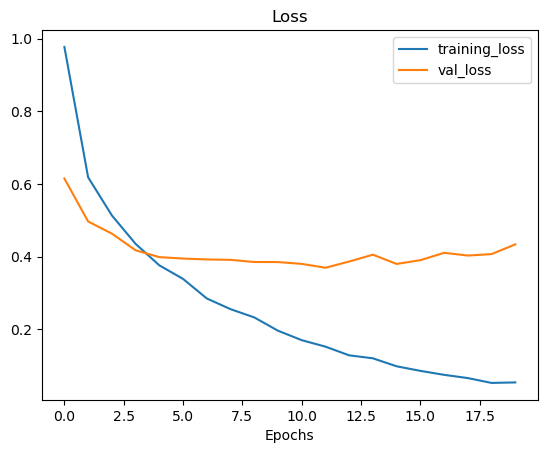

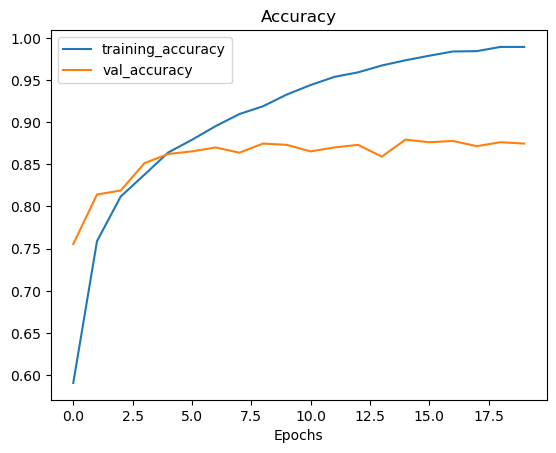

In [24]:
import matplotlib.pyplot as plt


loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(history.history['loss']))

# Plot loss
plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy, label='training_accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();

In [25]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 10 predictions: {pred[:10]}')

26/26 [==============================] - 22s 823ms/step
The first 10 predictions: ['paper', 'plastic', 'paper', 'paper', 'metal', 'paper', 'paper', 'paper', 'plastic', 'plastic']


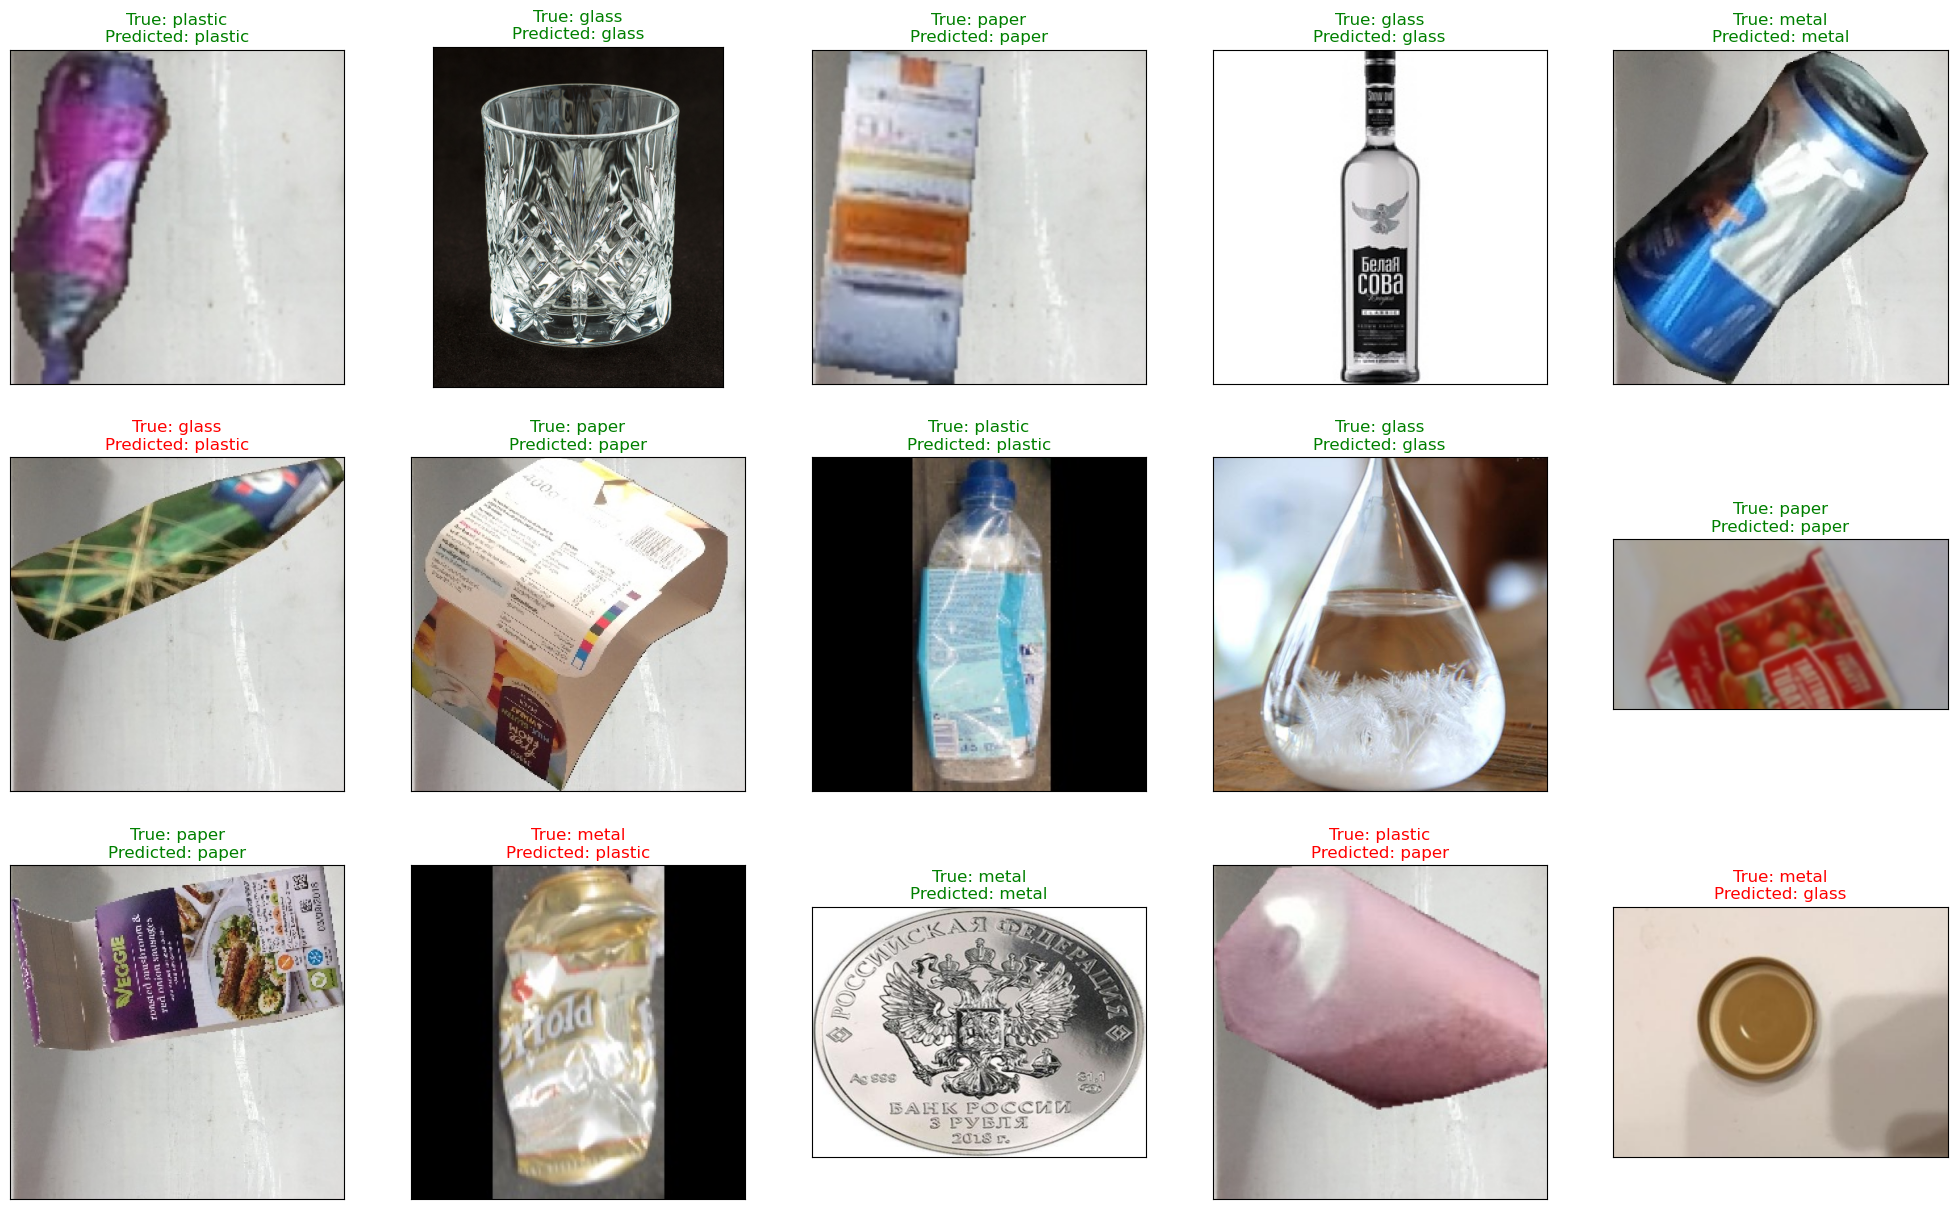

<Figure size 640x480 with 0 Axes>

In [26]:
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [27]:
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
glass,0.941520,0.936047,0.938776,172.000000
metal,0.838323,0.777778,0.806916,180.000000
paper,0.791367,0.894309,0.839695,246.000000
plastic,0.746114,0.682464,0.712871,211.000000
accuracy,0.822002,0.822002,0.822002,0.822002
macro avg,0.829331,0.822649,0.824564,809.000000
weighted avg,0.821936,0.822002,0.820389,809.000000


In [28]:
model.save('../Resnet50.h5')

/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
new_images = ['path/to/image1.jpg', 'path/to/image2.png']
new_images = np.array([
  [[0.123, 0.456, 0.789], ...],
  [[0.234, 0.567, 0.890], ...]
])

/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
def preprocess_images(new_images):
  if isinstance(new_images[0], str):
    preprocessed_images = []
    for image_path in new_images:
      img = cv2.imread(image_path) 
      img = cv2.resize(img, (224, 224))
      img = img.astype('float32') / 255.0  
      preprocessed_images.append(img)
    preprocessed_images = np.array(preprocessed_images)
  else:
    preprocessed_images = new_images.astype('float32') / 255.0 
  return preprocessed_images

In [31]:
model = tf.keras.models.load_model('../Resnet50.h5')
new_images = preprocess_images(new_images)
predictions = model.predict(new_images)
labels = (train_images.class_indices)
labels = dict((v, k) for k, v in labels.items())
predicted_classes = [labels[np.argmax(pred)] for pred in predictions]
print(f'Lớp dự đoán cho ảnh mới: {predicted_classes}')

NameError: name 'new_images' is not defined